# 2022/4/16
# 本代码计算CMIP6中CESM2提交的数据的降水情况
# 用以和我跑出来的模式结果进行对比

In [1]:
import os
import sys
import xarray as xr
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *

In [2]:
path_in  =  "/home/sun/mydown/cmip6/cesm2/"
f1       =  xr.open_dataset(path_in+"pr_day_CESM2_amip_r1i1p1f1_gn_19800101-19891231.nc")
f2       =  xr.open_dataset(path_in+"pr_day_CESM2_amip_r1i1p1f1_gn_19900101-19991231.nc")

/home/sun/.conda/envs/swh/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [3]:
# 声明一个平均的数组
prect  =  np.zeros((365,192,288))


for i in range(0,10):
    j = 0
    for ii in range(365):
        prect[ii,:]  +=  (f1.pr.data[i*365+j,:]+f2.pr.data[i*365+j,:])/20*86400
    
        j += 1
    


In [4]:
ncfile  =  xr.Dataset(
    {
        "prect": (["time", "lat", "lon"], prect),
    },
    coords={
        "lon": (["lon"], f1.lon.data),
        "lat": (["lat"], f1.lat.data),
        "time": (["time"], np.linspace(1,365,365)),
    },
)

In [5]:
time_slice      =  slice(100,200)
lat_slice       =  slice(12,20)
lon_slice       =  slice(55,145)
prect_con       =  ncfile["prect"].sel(time=time_slice,lat = lat_slice,lon = lon_slice)  

In [6]:
np.set_printoptions(suppress=True)
#Compute weights and take weighted average over latitude dimension
weights1  =  np.cos(np.deg2rad(prect_con.lat.values))

In [11]:
# 坐标轴设置
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('Blues', 28)
newcolors = viridis(np.linspace(0, 0.7, 14))
newcmp = ListedColormap(newcolors)
newcmp.set_under('white')
#newcmp.set_over('#0d35c7')

#levels
#clevs = np.arange(5,55,5)
clevs = np.arange(5,35,5)

# Tick labels
x_tick_labels = []
for xx in range(60,141,10):
    x_tick_labels.append(u''+str(xx)+"\N{DEGREE SIGN}E")

y_tick = [100,110,120,130,140,150,161,171,181,191,201]
y_label = ['11Apr','21Apr','1May','11May','21May','31May','11Jun','21Jun','1Jul','11Jul','21Jul']

[Text(0, 100, '11Apr'),
 Text(0, 110, '21Apr'),
 Text(0, 120, '1May'),
 Text(0, 130, '11May'),
 Text(0, 140, '21May'),
 Text(0, 150, '31May'),
 Text(0, 161, '11Jun'),
 Text(0, 171, '21Jun'),
 Text(0, 181, '1Jul'),
 Text(0, 191, '11Jul'),
 Text(0, 201, '21Jul')]

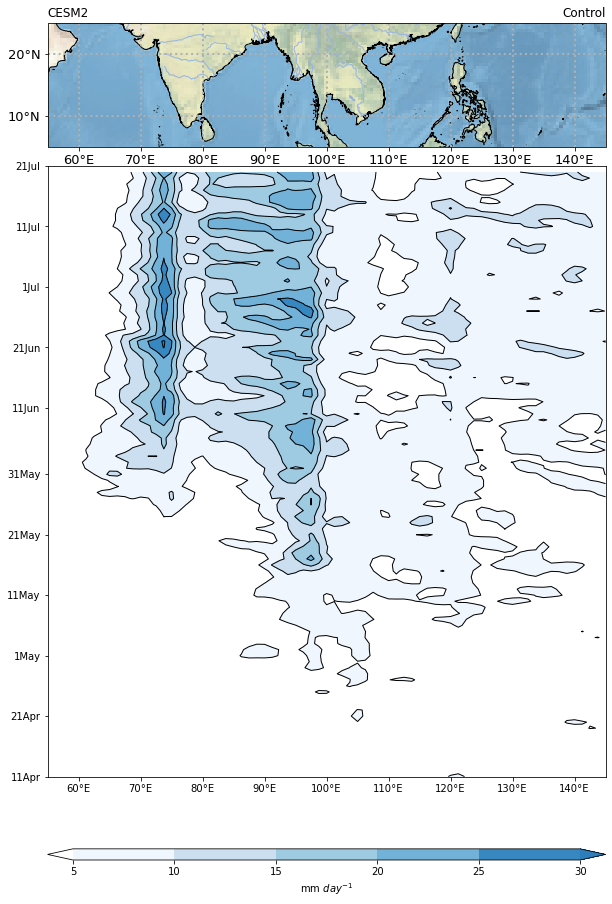

In [15]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import sys

# Start figure
fig = plt.figure(figsize=(10, 17.5))
# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)


# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([55, 145, 5, 25], ccrs.PlateCarree())
ax1.set_yticks([10, 20])
ax1.set_yticklabels([u'10\N{DEGREE SIGN}N', u'20\N{DEGREE SIGN}N'])
ax1.set_xticks(np.arange(60,141,10))
ax1.set_xticklabels(x_tick_labels)
ax1.tick_params(labelsize=13)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.05)
ax1.add_feature(cfeature.RIVERS)
ax1.add_feature(cfeature.LAKES)
ax1.stock_img()

# Set some titles
plt.title('CESM2', loc='left')
plt.title('Control', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
#cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, (prect_con*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1), clevs, cmap=newcmp, extend='both')
#cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, (prect_con*weights1[None, :, None]).sum(dim='lat')/np.sum(weights1), clevs, colors='k', linewidths=1)
cf   = ax2.contourf(prect_con.lon.values, prect_con.time.values, (prect_con*weights1[None, :, None]).mean(dim='lat'), clevs, cmap=newcmp, extend='both')
cs   = ax2.contour(prect_con.lon.values,  prect_con.time.values, (prect_con*weights1[None, :, None]).mean(dim='lat'), clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.09, aspect=50)
cbar.set_label('mm $day^{-1}$')

ax2.set_xticks(np.arange(60,141,10))
ax2.set_xticklabels(x_tick_labels)
ax2.tick_params(labelsize=10)

ax2.set_yticks(y_tick)
ax2.set_yticklabels(y_label)

In [15]:
prect

array([[[0.11710286, 0.11709695, 0.11709781, ..., 0.11709726,
         0.11709755, 0.11709763],
        [0.14801479, 0.14824711, 0.14860924, ..., 0.14767305,
         0.14797508, 0.14789419],
        [0.17951251, 0.17368642, 0.17017101, ..., 0.18835381,
         0.18592937, 0.18302521],
        ...,
        [0.67363648, 0.67056039, 0.66768417, ..., 0.68749319,
         0.68311874, 0.67824099],
        [0.62887267, 0.62830156, 0.62774968, ..., 0.63243457,
         0.63148844, 0.62998757],
        [0.52103244, 0.52091829, 0.52091176, ..., 0.52112971,
         0.52112951, 0.52112942]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 